In [16]:
import os
import json
import numpy as np
import tensorflow as tf

# Class names and mapping for one-hot encoding
class_name = ["SKU_1L", "SKU_4L", "SKU_10L_DTS", "SKU_10L_NDTS", "SKU_20L_DTS", "SKU_20L_NDTS"]
class_mapping = {class_name[i]: i for i in range(len(class_name))}
print(class_mapping)

# Folder path containing JSON files
folder_path = 'Json'

def parse_json_file(file_path):
    with open(file_path, 'r') as file:
        parsed_data = json.load(file)
    return parsed_data

def extract_features_targets(parsed_data):
    # Extract truck dimensions and total used SKUs
    truck_dimension = {item['key']: int(item['value']) for item in parsed_data['truckDimension']}
    total_used_skus = {item['skuName']: int(item['totalUsedSkusCount']) for item in parsed_data['totalUsedSkus']}
    
    # Extract SKU information
    sku_info_data = []
    for item in parsed_data['skusInfoData']:
        sku_name = item['skuName']
        skuLocalPosition = {pos['key']: float(pos['value']) for pos in item['skuLocalPosition']}
        
        one_hot = [0] * len(class_name)
        if sku_name in class_mapping:
            one_hot[class_mapping[sku_name]] = 1
        
        sku_info = [one_hot, [round(skuLocalPosition['x'], 2), round(skuLocalPosition['y'], 2), round(skuLocalPosition['z'], 2)]]
        sku_info_data.append(sku_info)
    
    # Create X_train entry
    X_train_entry = [
        truck_dimension['Length'], 
        truck_dimension['Width'], 
        truck_dimension['Height'], 
        total_used_skus['SKU_1L'],
        total_used_skus['SKU_4L'],
        total_used_skus['SKU_10L_DTS'],
        total_used_skus['SKU_10L_NDTS'],
        total_used_skus['SKU_20L_DTS'],
        total_used_skus['SKU_20L_NDTS']
    ]
    
    return X_train_entry, sku_info_data

def process_json_files(folder_path):
    X_train = []
    y_train = []
    json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]
    
    for json_file in json_files:
        file_path = os.path.join(folder_path, json_file)
        parsed_data = parse_json_file(file_path)
        X_train_entry, sku_info_data = extract_features_targets(parsed_data)
        
        X_train.append(X_train_entry)
        
        # Flatten positions and append to y_train
        positions = []
        for item in sku_info_data:
            positions.extend(item[1])
        y_train.append(positions)
    
    return np.array(X_train), y_train

# Process JSON files and prepare data
X_train, y_train = process_json_files(folder_path)

# Find the maximum length of positions
max_positions_length = max(len(positions) for positions in y_train)

# Pad positions to ensure uniform length
for i in range(len(y_train)):
    while len(y_train[i]) < max_positions_length:
        y_train[i].append(0)  # padding the positions

# Convert y_train to a numpy array
y_train = np.array(y_train)

max_y_train_value = np.max(y_train)

# Normalize data
X_train = tf.keras.utils.normalize(X_train, axis=1)
y_train = tf.keras.utils.normalize(y_train, axis=1)

# Print shapes of the data
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


{'SKU_1L': 0, 'SKU_4L': 1, 'SKU_10L_DTS': 2, 'SKU_10L_NDTS': 3, 'SKU_20L_DTS': 4, 'SKU_20L_NDTS': 5}
X_train shape: (167, 9)
y_train shape: (167, 5508)


In [2]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2048, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(y_train.shape[1], activation='linear')
])

model1.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print model summary
model1.summary()


/opt/anaconda3/envs/TF-Metal/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-12 17:59:51.049776: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-06-12 17:59:51.049795: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-06-12 17:59:51.049800: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-06-12 17:59:51.049819: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-12 17:59:51.049831: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2048)           │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5508)           │       710,532 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,518,212 (13.42 MB)

 Trainable params: 3,518,212 (13.42 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
# Train the model
history = model1.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.2)




Epoch 1/1000


2024-06-12 17:59:51.533703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 1.8681e-04 - mae: 0.0090 - val_loss: 1.3510e-04 - val_mae: 0.0070
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2866e-04 - mae: 0.0069 - val_loss: 9.9091e-05 - val_mae: 0.0061
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.5233e-05 - mae: 0.0060 - val_loss: 7.5850e-05 - val_mae: 0.0055
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.5170e-05 - mae: 0.0055 - val_loss: 6.1476e-05 - val_mae: 0.0051
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.2493e-05 - mae: 0.0052 - val_loss: 5.2194e-05 - val_mae: 0.0048
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.6313e-05 - mae: 0.0049 - val_loss: 4.6451e-05 - val_mae: 0.0044
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.0705e-05 - mae: 0.0046 - val_loss: 4.3428e-05 - val_mae: 0.0042
Epoch 8/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.7458e-05 - mae: 0.0044 - val_loss: 4.2034e-05 - val_mae: 0.0041
Epoch 9/1000


In [4]:
# Evaluate the model
loss, mae = model1.evaluate(X_train, y_train)
print(f'Model Loss: {loss}, Model MAE: {mae}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.8345e-05 - mae: 0.0031
Model Loss: 2.7921600121771917e-05, Model MAE: 0.0031059342436492443


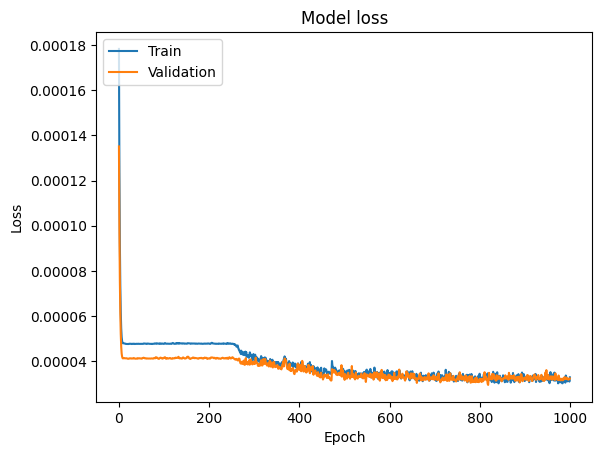

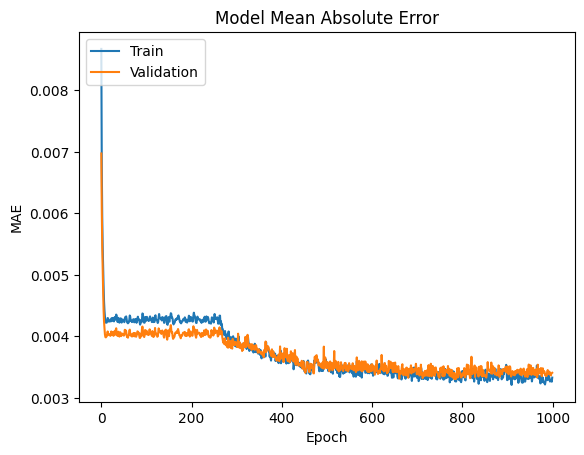

In [5]:
# Plot training & validation loss values
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation MAE values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Define a more complex model
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2048, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(y_train.shape[1], activation='linear')
])

# Compile the model with a different optimizer and a learning rate scheduler
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)

model2.compile(optimizer=optimizer, loss='mse', metrics=['mae'])



/opt/anaconda3/envs/TF-Metal/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 1.6547e-04 - mae: 0.0082 - val_loss: 1.0389e-04 - val_mae: 0.0061 - learning_rate: 0.0010
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9.4157e-05 - mae: 0.0062 - val_loss: 5.6686e-05 - val_mae: 0.0048 - learning_rate: 0.0010
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.1562e-05 - mae: 0.0053 - val_loss: 4.5124e-05 - val_mae: 0.0043 - learning_rate: 0.0010
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.1203e-05 - mae: 0.0047 - val_loss: 4.3329e-05 - val_mae: 0.0042 - learning_rate: 0.0010
Epoch 5/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.9072e-05 - mae: 0.0045 - val_loss: 4.1830e-05 - val_mae: 0.0041 - learning_rate: 0.0010
Epoch 6/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.7777e-05 - mae: 0.0043 - val_loss: 4.1722e-05 - val_mae: 0.0041 - learning_rate: 0.0010
Epoch 7/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.9007e-05 - mae: 0.0044 - val_loss: 4.1515e-05

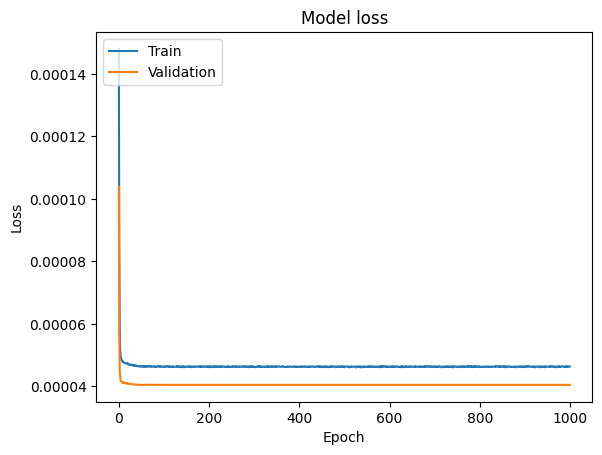

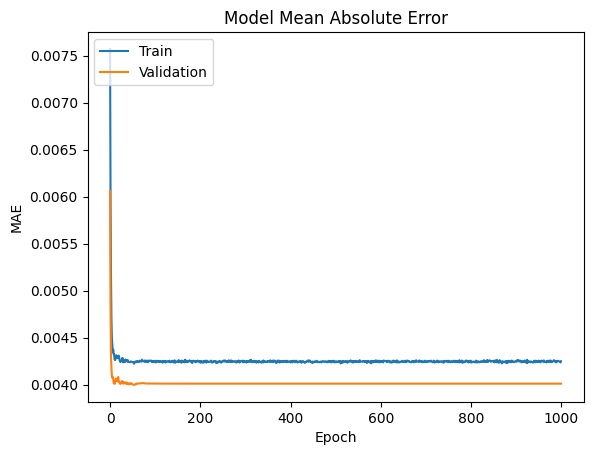

In [7]:
# Train the model with a learning rate scheduler
history = model2.fit(X_train, y_train, epochs=1000, batch_size=16, validation_split=0.2, callbacks=[lr_scheduler])

# Evaluate the model
loss, mae = model2.evaluate(X_train, y_train)
print(f'Model Loss: {loss}, Model MAE: {mae}')

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation MAE values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# approach 3


In [8]:
import tensorflow as tf
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

# Define a more complex model with batch normalization and L2 regularization
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2048, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(y_train.shape[1], activation='linear')
])





In [9]:
# Compile the model with a different optimizer and a learning rate scheduler
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)

model3.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Train the model with a learning rate scheduler
history = model3.fit(X_train, y_train, epochs=1000, batch_size=16, validation_split=0.2, callbacks=[lr_scheduler])

Epoch 1/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 2.5075 - mae: 0.1957 - val_loss: 2.0923 - val_mae: 0.0098 - learning_rate: 0.0010
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.0330 - mae: 0.1674 - val_loss: 1.6580 - val_mae: 0.0106 - learning_rate: 0.0010
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.5955 - mae: 0.1366 - val_loss: 1.2805 - val_mae: 0.0112 - learning_rate: 0.0010
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.2216 - mae: 0.1086 - val_loss: 0.9673 - val_mae: 0.0104 - learning_rate: 0.0010
Epoch 5/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.9182 - mae: 0.0893 - val_loss: 0.7206 - val_mae: 0.0098 - learning_rate: 0.0010
Epoch 6/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.6826 - mae: 0.0739 - val_loss: 0.5346 - val_mae: 0.0088 - learning_rate: 0.0010
Epoch 7/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.5064 - mae: 0.0640 - val_loss: 0.3951 - val_mae: 0.0084 - learning_rate: 0.0010
Epoch 8/1000

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.7733e-05 - mae: 0.0037
Model Loss: 6.717447831761092e-05, Model MAE: 0.0036949573550373316


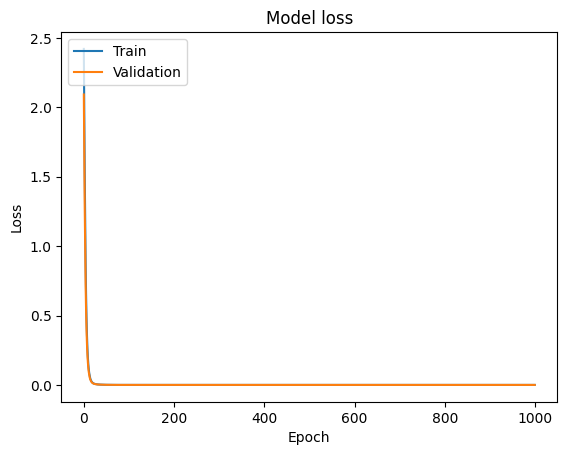

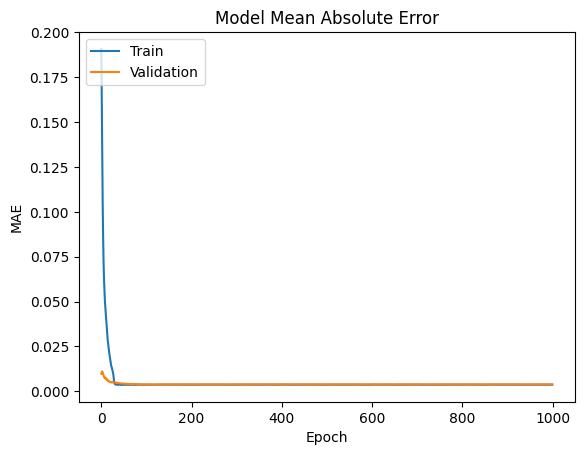

In [10]:
# Evaluate the model
loss, mae = model3.evaluate(X_train, y_train)
print(f'Model Loss: {loss}, Model MAE: {mae}')

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation MAE values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
model1.save("model1.keras")

In [13]:
model2.save("model2.keras")
model3.save("model3.keras")

# Predictions

In [18]:
import tensorflow as tf
import numpy as np

# Assuming the model is already trained and loaded

# Example input data
input_data = {
    'Length': 80,
    'Width': 31,
    'Height': 20,
    'SKU_1L': 200,
    'SKU_4L': 120,
    'SKU_10L_DTS': 300,
    'SKU_10L_NDTS': 396,
    'SKU_20L_DTS': 231,
    'SKU_20L_NDTS': 165
}

# Convert input data to list
input_list = [
    input_data['Length'],
    input_data['Width'],
    input_data['Height'],
    input_data['SKU_1L'],
    input_data['SKU_4L'],
    input_data['SKU_10L_DTS'],
    input_data['SKU_10L_NDTS'],
    input_data['SKU_20L_DTS'],
    input_data['SKU_20L_NDTS']
]

# Normalize input data if needed
input_list = tf.keras.utils.normalize([input_list], axis=1)

# Make predictions using the model
predicted_positions = model1.predict(input_list)

# Assuming y_train was normalized, denormalize the predictions
max_position_value = 100  # Replace with the actual value used for normalization
predicted_positions = predicted_positions * max_y_train_value

# Flatten the predicted positions if needed
predicted_positions = predicted_positions.flatten()

# Convert the predicted positions into a structured format
sku_names = ["SKU_1L", "SKU_4L", "SKU_10L_DTS", "SKU_10L_NDTS", "SKU_20L_DTS", "SKU_20L_NDTS"]
predicted_output = {}
position_index = 0

# Assuming each SKU has multiple positions, distribute the positions accordingly
for sku in sku_names:
    sku_positions = []
    for _ in range(input_data[sku]):
        position = {
            'x': predicted_positions[position_index],
            'y': predicted_positions[position_index + 1],
            'z': predicted_positions[position_index + 2]
        }
        sku_positions.append(position)
        position_index += 3
    predicted_output[sku] = sku_positions

# Print the predicted output
for sku, positions in predicted_output.items():
    print(f"{sku}: {positions[:5]}")  # Print the first 5 positions for brevity


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
SKU_1L: [{'x': -5.681393e-05, 'y': -0.00039864564, 'z': 0.00087068713}, {'x': -0.0018281225, 'y': 0.00022958325, 'z': 0.1877604}, {'x': -0.00090617675, 'y': 0.00081575214, 'z': 0.36506426}, {'x': -0.00018426236, 'y': -0.0014295169, 'z': 0.544562}, {'x': 9.821801e-05, 'y': -0.0011893762, 'z': 0.73143506}]
SKU_4L: [{'x': 0.53635365, 'y': 0.4310443, 'z': 0.5353486}, {'x': 0.53382134, 'y': 0.43304253, 'z': 0.6983415}, {'x': 0.5469605, 'y': 0.34849215, 'z': 0.74686366}, {'x': 0.54794765, 'y': 0.35847765, 'z': 0.7070441}, {'x': 0.5521937, 'y': 0.34124887, 'z': 0.66037756}]
SKU_10L_DTS: [{'x': 0.86935145, 'y': 0.4742374, 'z': 0.43957523}, {'x': 0.8721701, 'y': 0.46514407, 'z': 0.49745324}, {'x': 0.8767318, 'y': 0.4555812, 'z': 0.5699282}, {'x': 0.878675, 'y': 0.44839793, 'z': 0.7117595}, {'x': 0.8828234, 'y': 0.46183386, 'z': 0.60610116}]
SKU_10L_NDTS: [{'x': 1.7544872, 'y': 0.3869229, 'z': 0.5566132}, {'x': 1.762311, 'y': 0.37293622, 'z': 0.64355886}, {'